In [12]:
import torch
import torch.nn as nn
import numpy as np
from scipy import integrate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.autograd as autograd

In [13]:
class FeedForwardNN(nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(3, 10)  # input layer
        self.fc2 = nn.Linear(10, 10)  # hidden layer 1
        self.fc3 = nn.Linear(10, 10)  # hidden layer 2
        self.fc4 = nn.Linear(10, 3)  # output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # no activation function for the output layer in a regression task
        return x

modelNN = FeedForwardNN()

In [14]:
# Define the Lorenz system
def lorenz_deriv(x_y_z, t0, sigma=10, beta=8/3, rho=28):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

# Set up time span, initial conditions, and rho values
dt = 0.01
T = 8
t = np.arange(0, T+dt, dt)
np.random.seed(123)
x0 = -15 + 30 * np.random.random((100, 3))
rhos = [10, 28, 40]

# Solve the Lorenz equations
nn_input = []
nn_output = []

for rho in rhos:
    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t, args=(10, 8/3, rho)) for x0_j in x0])
    nn_input.append(x_t[:, :-1, :].reshape(-1, 3))  # reshaping the array to the form (samples, features)
    nn_output.append(x_t[:, 1:, :].reshape(-1, 3))

nn_input = np.concatenate(nn_input)
nn_output = np.concatenate(nn_output)

# Normalize the data
scaler_in = StandardScaler()
scaler_out = StandardScaler()
nn_input = scaler_in.fit_transform(nn_input)
nn_output = scaler_out.fit_transform(nn_output)

# Split the dataset into a training set and a validation set
nn_input_train, nn_input_val, nn_output_train, nn_output_val = train_test_split(nn_input, nn_output, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
nn_input_train = torch.from_numpy(nn_input_train).float()
nn_output_train = torch.from_numpy(nn_output_train).float()
nn_input_val = torch.from_numpy(nn_input_val).float()
nn_output_val = torch.from_numpy(nn_output_val).float()


In [15]:
# Define the loss function
loss_fn = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(modelNN.parameters(), lr=0.01)

# Define a helper function for the training process
def train(model, optimizer, loss_fn, inputs, targets, n_epochs=100):
    model.train()
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        if (epoch+1) % 20 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}")

# Train the model
train(modelNN, optimizer, loss_fn, nn_input_train, nn_output_train, n_epochs=100)

# Evaluate the model on the validation set
modelNN.eval()
with torch.no_grad():
    predictions = modelNN(nn_input_val)

# Compute the Mean Squared Error of the predictions
mse = loss_fn(predictions, nn_output_val)
print(f"Mean Squared Error (MSE) on the validation set: {mse.item()}")

Epoch 20/100, Loss: 0.45257505774497986
Epoch 40/100, Loss: 0.07307202368974686
Epoch 60/100, Loss: 0.04627729579806328
Epoch 80/100, Loss: 0.03990839794278145
Epoch 100/100, Loss: 0.03579522669315338
Mean Squared Error (MSE) on the validation set: 0.03502427414059639


In [16]:
# Solve the Lorenz equations for rho = 17 and rho = 35
test_rhos = [17, 35]
test_input = []
test_output = []

for rho in test_rhos:
    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t, args=(10, 8/3, rho)) for x0_j in x0])
    test_input.append(x_t[:, :-1, :].reshape(-1, 3))  
    test_output.append(x_t[:, 1:, :].reshape(-1, 3))

test_input = np.concatenate(test_input)
test_output = np.concatenate(test_output)

# Normalize the test data
test_input = scaler_in.transform(test_input)
test_output = scaler_out.transform(test_output)

# Convert to PyTorch tensors
test_input = torch.from_numpy(test_input).float()
test_output = torch.from_numpy(test_output).float()

# Use the trained model to predict the states at rho = 17 and rho = 35
modelNN.eval()
with torch.no_grad():
    predictions = modelNN(test_input)

# Compute the Mean Squared Error of the predictions
mse_test = loss_fn(predictions, test_output)
print(f"Mean Squared Error (MSE) on the test set: {mse_test.item()}")

Mean Squared Error (MSE) on the test set: 0.030336596071720123


In [17]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=3, hidden_size=10, num_layers=1)
        self.fc = nn.Linear(in_features=10, out_features=3)
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

modelLSTM = LSTMModel()

# Set up time span, initial conditions, and rho values
dt = 0.01
T = 8
t = np.arange(0, T+dt, dt)
np.random.seed(123)
x0 = -15 + 30 * np.random.random((100, 3))
rhos = [10, 28, 40]

# Solve the Lorenz equations
nn_input_lstm = []
nn_output_lstm = []

for rho in rhos:
    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t, args=(10, 8/3, rho)) for x0_j in x0])
    nn_input_lstm.append(x_t[:, :-1, :].reshape(-1, 3))  # reshaping the array to the form (samples, features)
    nn_output_lstm.append(x_t[:, 1:, :].reshape(-1, 3))

nn_input_lstm = np.concatenate(nn_input_lstm)
nn_output_lstm = np.concatenate(nn_output_lstm)

# Normalize the data
scaler_in_lstm = StandardScaler()
scaler_out_lstm = StandardScaler()
nn_input_lstm = scaler_in_lstm.fit_transform(nn_input_lstm)
nn_output_lstm = scaler_out_lstm.fit_transform(nn_output_lstm)

# Split the dataset into a training set and a validation set
nn_input_lstm_train, nn_input_lstm_val, nn_output_lstm_train, nn_output_lstm_val = train_test_split(nn_input_lstm, nn_output_lstm, test_size=0.2, random_state=42)

# Reshape the input data to be suitable for LSTM
nn_input_lstm_train = nn_input_lstm_train.reshape(-1, 1, 3)
nn_input_lstm_val = nn_input_lstm_val.reshape(-1, 1, 3)

# Convert to PyTorch tensors
nn_input_lstm_train = torch.from_numpy(nn_input_lstm_train).float()
nn_output_lstm_train = torch.from_numpy(nn_output_lstm_train).float()
nn_input_lstm_val = torch.from_numpy(nn_input_lstm_val).float()
nn_output_lstm_val = torch.from_numpy(nn_output_lstm_val).float()

# Define the loss function
loss_fn_lstm = nn.MSELoss()

# Define the optimizer
optimizer_lstm = optim.Adam(modelLSTM.parameters(), lr=0.01)

# Define a helper function for the training process
def train_lstm(model, optimizer, loss_fn, inputs, targets, n_epochs=100):
    model.train()
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        if (epoch+1) % 20 == 0:
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}")

# Train the LSTM model
train_lstm(modelLSTM, optimizer_lstm, loss_fn_lstm, nn_input_lstm_train, nn_output_lstm_train, n_epochs=100)

# Evaluate the LSTM model on the validation set
modelLSTM.eval()
with torch.no_grad():
    predictions_lstm = modelLSTM(nn_input_lstm_val)

# Compute the Mean Squared Error of the predictions
mse_lstm = loss_fn_lstm(predictions_lstm.squeeze(), nn_output_lstm_val)
print(f"Mean Squared Error (MSE) on the validation set: {mse_lstm.item()}")

# Solve the Lorenz equations for rho = 17 and rho = 35
test_rhos = [17, 35]
test_input_lstm = []
test_output_lstm = []

for rho in test_rhos:
    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t, args=(10, 8/3, rho)) for x0_j in x0])
    test_input_lstm.append(x_t[:, :-1, :].reshape(-1, 3))  
    test_output_lstm.append(x_t[:, 1:, :].reshape(-1, 3))

test_input_lstm = np.concatenate(test_input_lstm)
test_output_lstm = np.concatenate(test_output_lstm)

# Normalize the test data
test_input_lstm = scaler_in_lstm.transform(test_input_lstm)
test_output_lstm = scaler_out_lstm.transform(test_output_lstm)

# Reshape the input data to be suitable for LSTM
test_input_lstm = test_input_lstm.reshape(-1, 1, 3)

# Convert to PyTorch tensors
test_input_lstm = torch.from_numpy(test_input_lstm).float()
test_output_lstm = torch.from_numpy(test_output_lstm).float()

# Use the trained LSTM model to predict the states at rho = 17 and rho = 35
modelLSTM.eval()
with torch.no_grad():
    predictions_lstm = modelLSTM(test_input_lstm)

# Compute the Mean Squared Error of the predictions
mse_test_lstm = loss_fn_lstm(predictions_lstm.squeeze(), test_output_lstm)
print(f"Mean Squared Error (MSE) on the test set: {mse_test_lstm.item()}")


Epoch 20/100, Loss: 0.4708504378795624
Epoch 40/100, Loss: 0.14615674316883087
Epoch 60/100, Loss: 0.058778394013643265
Epoch 80/100, Loss: 0.04756217077374458
Epoch 100/100, Loss: 0.04165666922926903
Mean Squared Error (MSE) on the validation set: 0.040789078921079636
Mean Squared Error (MSE) on the test set: 0.033271465450525284


In [18]:
# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x.unsqueeze(1))
        out = self.fc(out.squeeze(1))
        return out

# Set up time span, initial conditions, and rho values
dt = 0.01
T = 8
t = np.arange(0, T+dt, dt)
np.random.seed(123)
x0 = -15 + 30 * np.random.random((100, 3))
rhos = [10, 28, 40]

# Solve the Lorenz equations
nn_input = []
nn_output = []

for rho in rhos:
    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t, args=(10, 8/3, rho)) for x0_j in x0])
    nn_input.append(x_t[:, :-1, :].reshape(-1, 3))  # reshaping the array to the form (samples, features)
    nn_output.append(x_t[:, 1:, :].reshape(-1, 3))

nn_input = np.concatenate(nn_input)
nn_output = np.concatenate(nn_output)

# Normalize the data
scaler_in = StandardScaler()
scaler_out = StandardScaler()
nn_input = scaler_in.fit_transform(nn_input)
nn_output = scaler_out.fit_transform(nn_output)

# Split the dataset into a training set and a validation set
nn_input_train, nn_input_val, nn_output_train, nn_output_val = train_test_split(nn_input, nn_output, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
nn_input_train = torch.from_numpy(nn_input_train).float()
nn_output_train = torch.from_numpy(nn_output_train).float()
nn_input_val = torch.from_numpy(nn_input_val).float()
nn_output_val = torch.from_numpy(nn_output_val).float()

# Create the model
input_size = 3
hidden_size = 50
output_size = 3
modelNN = RNNModel(input_size, hidden_size, output_size)

# Define the loss function
loss_fn = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(modelNN.parameters(), lr=0.01)

# Train the model
train(modelNN, optimizer, loss_fn, nn_input_train, nn_output_train, n_epochs=100)

# Evaluate the model on the validation set
modelNN.eval()
with torch.no_grad():
  predictions = modelNN(nn_input_val)

# Compute the Mean Squared Error of the predictions
mse = loss_fn(predictions, nn_output_val)
print(f"Mean Squared Error (MSE) on the validation set: {mse.item()}")

# Solve the Lorenz equations for rho = 17 and rho = 35
test_rhos = [17, 35]
test_input = []
test_output = []

for rho in test_rhos:
  x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t, args=(10, 8/3, rho)) for x0_j in x0])
  test_input.append(x_t[:, :-1, :].reshape(-1, 3))
  test_output.append(x_t[:, 1:, :].reshape(-1, 3))

test_input = np.concatenate(test_input)
test_output = np.concatenate(test_output)

# Normalize the test data
test_input = scaler_in.transform(test_input)
test_output = scaler_out.transform(test_output)

# Convert to PyTorch tensors
test_input = torch.from_numpy(test_input).float()
test_output = torch.from_numpy(test_output).float()

# Use the trained model to predict the states at rho = 17 and rho = 35
modelNN.eval()
with torch.no_grad():
  predictions = modelNN(test_input)

# Compute the Mean Squared Error of the predictions
mse_test = loss_fn(predictions, test_output)
print(f"Mean Squared Error (MSE) on the test set: {mse_test.item()}")

Epoch 20/100, Loss: 0.06427261978387833
Epoch 40/100, Loss: 0.012278225272893906
Epoch 60/100, Loss: 0.006393828429281712
Epoch 80/100, Loss: 0.004487699829041958
Epoch 100/100, Loss: 0.0037660934031009674
Mean Squared Error (MSE) on the validation set: 0.0036187651567161083
Mean Squared Error (MSE) on the test set: 0.002631165087223053


In [19]:
# Define the ESN model
class EchoStateNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, spectral_radius=0.9):
        super(EchoStateNetwork, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.spectral_radius = spectral_radius

        # Define the ESN reservoir weights (randomly initialized)
        self.reservoir_weights = nn.Parameter(torch.randn(hidden_size, hidden_size))

        # Scale the reservoir weights by the spectral radius
        eigvals = torch.linalg.eigvals(self.reservoir_weights)
        max_eigval = torch.max(torch.abs(eigvals))
        self.reservoir_weights.data *= spectral_radius / max_eigval

        # Define the input-to-reservoir weights (randomly initialized)
        self.input_weights = nn.Parameter(torch.randn(hidden_size, input_size))

        # Define the reservoir-to-output weights (randomly initialized)
        self.output_weights = nn.Parameter(torch.randn(output_size, hidden_size))

        # Define the activation function (tanh)
        self.activation = nn.Tanh()

    def forward(self, x):
        batch_size = x.size(0)
        time_steps = x.size(1)

        # Reshape input tensor
        x = x.view(-1, self.input_size)

        # Initialize the hidden state of the reservoir
        reservoir_state = torch.zeros(batch_size, self.hidden_size)

        # Iterate through time steps
        for t in range(time_steps):
            # Update the reservoir state
            reservoir_state = self.activation(torch.mm(x[t].unsqueeze(0), self.input_weights.t()) + torch.mm(reservoir_state, self.reservoir_weights.t()))

        # Compute the output
        output = torch.mm(reservoir_state, self.output_weights.t())

        return output




# Set up time span, initial conditions, and rho values
dt = 0.01
T = 8
t = np.arange(0, T+dt, dt)
np.random.seed(123)
x0 = -15 + 30 * np.random.random((100, 3))
rhos = [10, 28, 40]

# Solve the Lorenz equations
nn_input = []
nn_output = []

for rho in rhos:
    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t, args=(10, 8/3, rho)) for x0_j in x0])
    nn_input.append(x_t[:, :-1, :].reshape(-1, 3))  # reshaping the array to the form (samples, features)
    nn_output.append(x_t[:, 1:, :].reshape(-1, 3))

nn_input = np.concatenate(nn_input)
nn_output = np.concatenate(nn_output)

# Normalize the data
scaler_in = StandardScaler()
scaler_out = StandardScaler()
nn_input = scaler_in.fit_transform(nn_input)
nn_output = scaler_out.fit_transform(nn_output)

# Split the dataset into a training set and a validation set
nn_input_train, nn_input_val, nn_output_train, nn_output_val = train_test_split(nn_input, nn_output, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
nn_input_train = torch.from_numpy(nn_input_train).float()
nn_output_train = torch.from_numpy(nn_output_train).float()
nn_input_val = torch.from_numpy(nn_input_val).float()
nn_output_val = torch.from_numpy(nn_output_val).float()

# Create the ESN model
input_size = 3
hidden_size = 50
output_size = 3
modelESN = EchoStateNetwork(input_size, hidden_size, output_size)

# Define the loss function
loss_fn = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(modelESN.parameters(), lr=0.01)

# Enable anomaly detection
autograd.set_detect_anomaly(True)

# Train the model
train(modelESN, optimizer, loss_fn, nn_input_train, nn_output_train, n_epochs=100)

# Evaluate the model on the validation set
modelESN.eval()
with torch.no_grad():
  predictions = modelESN(nn_input_val)

# Compute the Mean Squared Error of the predictions
mse = loss_fn(predictions, nn_output_val)
print(f"Mean Squared Error (MSE) on the validation set: {mse.item()}")

# Solve the Lorenz equations for rho = 17 and rho = 35
test_rhos = [17, 35]
test_input = []
test_output = []

for rho in test_rhos:
  x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t, args=(10, 8/3, rho)) for x0_j in x0])
  test_input.append(x_t[:, :-1, :].reshape(-1, 3))
  test_output.append(x_t[:, 1:, :].reshape(-1, 3))

test_input = np.concatenate(test_input)
test_output = np.concatenate(test_output)

# Normalize the test data
test_input = scaler_in.transform(test_input)
test_output = scaler_out.transform(test_output)

# Convert to PyTorch tensors
test_input = torch.from_numpy(test_input).float()
test_output = torch.from_numpy(test_output).float()

# Use the trained model to predict the states at rho = 17 and rho = 35
modelESN.eval()
with torch.no_grad():
  predictions = modelESN(test_input)

# Compute the Mean Squared Error of the predictions
mse_test = loss_fn(predictions, test_output)
print(f"Mean Squared Error (MSE) on the test set: {mse_test.item()}")


Epoch 20/100, Loss: 1.1498240232467651
Epoch 40/100, Loss: 1.0299972295761108
Epoch 60/100, Loss: 1.0050139427185059
Epoch 80/100, Loss: 1.0000767707824707
Epoch 100/100, Loss: 0.9994813203811646
Mean Squared Error (MSE) on the validation set: 39.69565963745117
Mean Squared Error (MSE) on the test set: 97.2642593383789


<ipython-input-20-0bceeb1f2b23>:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


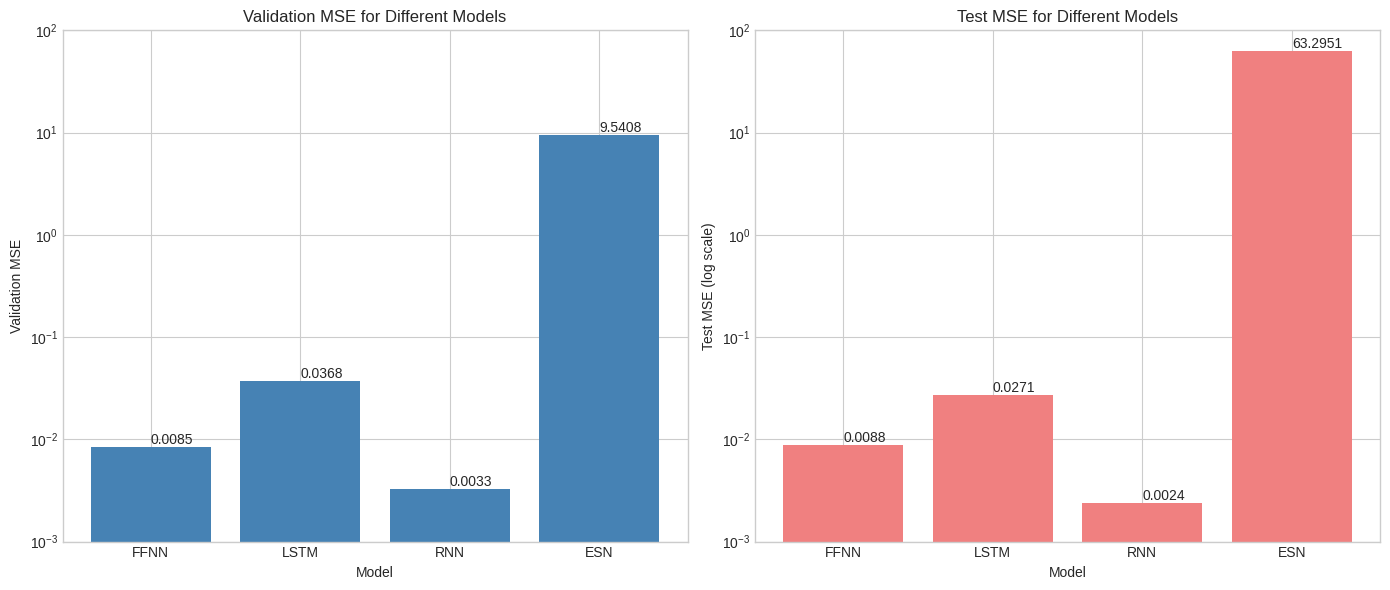

In [20]:
import matplotlib.pyplot as plt
import numpy as np

models = ['FFNN', 'LSTM', 'RNN', 'ESN']
validation_mse = [0.0085, 0.0368, 0.0033, 9.5408]
test_mse = [0.0088, 0.0271, 0.0024, 63.2951]

# Set figure size and style
plt.figure(figsize=(14, 6))
plt.style.use('seaborn-whitegrid')

# Subplot 1: Validation MSE
plt.subplot(1, 2, 1)
bar_plot = plt.bar(models, validation_mse, color='steelblue')
plt.ylabel('Validation MSE')
plt.xlabel('Model')
plt.yscale('log')
plt.ylim([1e-3, 1e2])  # Set the same y-axis limits
plt.title('Validation MSE for Different Models')

# Add the data value on top of the bars
for bar in bar_plot:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval,4), va='bottom')  # va: vertical alignment

# Subplot 2: Test MSE
plt.subplot(1, 2, 2)
bar_plot = plt.bar(models, test_mse, color='lightcoral')
plt.ylabel('Test MSE (log scale)')
plt.xlabel('Model')
plt.yscale('log')
plt.ylim([1e-3, 1e2])  # Set the same y-axis limits
plt.title('Test MSE for Different Models')

# Add the data value on top of the bars
for bar in bar_plot:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval,4), va='bottom')  # va: vertical alignment

# Display the plots
plt.tight_layout()
plt.show()